# HomeWork 3 Tracjectory Planning and Speed Control 
**67340700403 พีรดนย์ เรืองแก้ว**

## Import libraries

In [2]:
import time
import sys
import pathlib
import os
import numpy as np
from spatialmath import SE3
from scipy.spatial.transform import Rotation
import pathlib
from spatialmath import SE3, UnitQuaternion

notebook_path = os.getcwd()
sys.path.append(str(pathlib.Path(notebook_path).parent))
from classrobot.robot_movement import RobotControl
from classrobot.UR5e_DH import UR5eDH
from classrobot.planning import Planning



## Define Position
ขั้นตอนแรกสำหรับการทำ trajectory planning คือการกำหนดตำแหน่งเริ่มต้นและตำแหน่งเป้าหมายของหุ่นยนต์ในรูปแบบของพ้อยท์ 3 มิติ (x, y, z) 

ในที่นี้เราจะกำหนดจุดเริ่มต้นเป็น `HOME_POS` และจุดเป้าหมายเป็น `GOAL_POS`

In [3]:
RPY = [-1.7318443587261685, 0.686842056802218, -1.7312759524010408]
HOME_POS = [0.701172053107018, 0.184272460738082, 0.1721568294843568] + RPY
GOAL_POS = [0.9035034184486379, 0.18425659123476879, -0.43708867396716417] + RPY


print("HOME:", HOME_POS)
print("GOAL:", GOAL_POS)

HOME: [0.701172053107018, 0.184272460738082, 0.1721568294843568, -1.7318443587261685, 0.686842056802218, -1.7312759524010408]
GOAL: [0.9035034184486379, 0.18425659123476879, -0.43708867396716417, -1.7318443587261685, 0.686842056802218, -1.7312759524010408]


## load DH table and initialization UR5e robot
โหลด DH table และทำการ initialize หุ่นยนต์ UR5e โดย class ทั้งสองจะโหลดจากโฟล์เดอร์ `classrobot` สามารถดูรายละเอียดเพิ่มเติมได้ที่ [UR5e_DH](./classrobot/UR5e_DH.py) และ [UR5e_control](./classrobot/robot_movement.py) 


In [4]:
# Robot UR5e DH parameters
# init DH TABLE
robotDH = UR5eDH()
tool_offset = SE3(0, 0, 0.200)
robotDH.tool = tool_offset
print(robotDH)

# ---- Init real robot ur5e ----

robot_ip = "192.168.200.10"
real_robot = RobotControl()
real_robot.robot_release()
real_robot.robot_init(robot_ip)
# make sure the robot is in home position
real_robot.robot_move_home()



DHRobot: UR5e (by Universal Robotics), 6 joints (RRRRRR), dynamics, standard DH parameters
┌─────┬────────┬─────────┬────────┐
│ θⱼ  │   dⱼ   │   aⱼ    │   ⍺ⱼ   │
├─────┼────────┼─────────┼────────┤
│  q1 │ 0.1625 │       0 │  90.0° │
│  q2 │      0 │  -0.425 │   0.0° │
│  q3 │      0 │ -0.3922 │   0.0° │
│  q4 │ 0.1333 │       0 │  90.0° │
│  q5 │ 0.0997 │       0 │ -90.0° │
│  q6 │ 0.0996 │       0 │   0.0° │
└─────┴────────┴─────────┴────────┘

┌──────┬─────────────────────────────────────┐
│ tool │ t = 0, 0, 0.2; rpy/xyz = 0°, 0°, 0° │
└──────┴─────────────────────────────────────┘

┌────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│   name │ q0     │ q1     │ q2     │ q3     │ q4     │ q5     │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│ q_HOME │  40.2° │  10.6° │  9.86° │ -99.2° │  39.4° │ -99.2° │
└────────┴────────┴────────┴────────┴────────┴────────┴────────┘

Moving to home position...
Arrived at home position.


## Crate Matrix transformation
ทำการสร้าง matrix transformation จาก input HOME_POS และ GOAL_POS ทั้งจุดเริ่มต้นและจุดเป้าหมาย สำหรับ HOME_POS จะเป็ฯการดคึงค่าตำแหน่ง TCP ปัจจุบันมาใช้เลยเพื่อลดการ error ในการคำนวน เนื่องจากก่อนหน้านี้เราได้สั่งให้ไปยังตำแหน่งนี้แล้ว

In [5]:
# --- Get current TCP pose from real robot ---
pos_current = real_robot.robot_get_position()
T_current = (
    SE3(pos_current[0], pos_current[1], pos_current[2])
    @ SE3.RPY(pos_current[3], pos_current[4], pos_current[5], unit='rad')
)


# --- Define goal TCP pose ---
pos_end = GOAL_POS
T_end = (
    SE3(pos_end[0], pos_end[1], pos_end[2])
    @ SE3.RPY(pos_end[3], pos_end[4], pos_end[5], unit='rad')
)

print("Start TCP Pose:\n", T_current)
print("End TCP Pose:\n", T_end)

Start TCP Pose:
   -0.1235   -0.05841   0.9906    0.7012    
  -0.7633    0.6435   -0.05726   0.1843    
  -0.6341   -0.7633   -0.1241    0.1721    
   0         0         0         1         

End TCP Pose:
   -0.1236   -0.05828   0.9906    0.9035    
  -0.7633    0.6435   -0.05735   0.1843    
  -0.6341   -0.7632   -0.124    -0.4371    
   0         0         0         1         



Current joint position:
 [0.7144890427589417, -1.9380299053587855, -2.052056074142456, -2.271982332269186, -0.9003184477435511, 2.3653526306152344]
FK position:
    0.02029   0.04228   0.9989    0.6993    
  -0.7225   -0.69      0.04388   0.1837    
   0.6911   -0.7226    0.01654   0.1702    
   0         0         0         1         



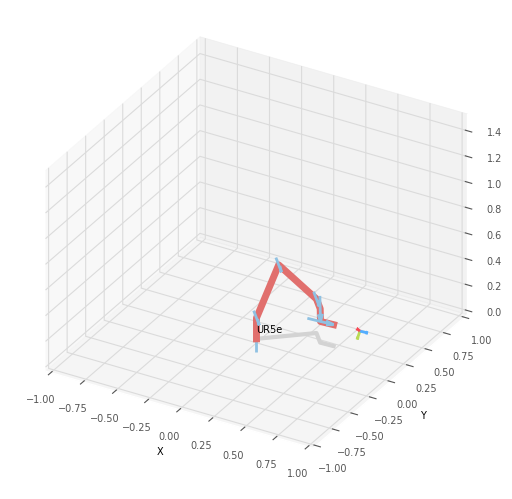

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'UR5e')

<Figure size 640x480 with 0 Axes>

In [6]:
# visualize the robot at Home position
# --- Forward kinematics: compute FK pose from current joint angles ---
# --- use in homework forward and inverse kinematics ---
joint_position = real_robot.robot_get_joint_rad()
print("Current joint position:\n", joint_position)

robotDH.q = joint_position
T_fk = robotDH.fkine(robotDH.q)
print("FK position:\n", T_fk)
robotDH.plot(joint_position, block=False, limits=[-1, 1, -1, 1, 0, 1.5],vellipse=False)

## Cubic polynomial trajectory planning


1. **กำหนดพารามิเตอร์หลัก**  
   - `dt` ความละเอียดเวลาสำหรับการแบ่งช่วง trajectory  
   - `speed` ความเร็วเชิงเส้นหรือมุมสูงสุด  
   - `acceleration` ค่าสูงสุดของความเร่ง  

2. **โหลดค่า start/goal pose**  
   - อ่านตำแหน่งและมุมปัจจุบันจากเซนเซอร์  
   - กำหนด HOME_POS เป็นเป้าหมาย  

3. **ประมาณระยะเวลาและเลือกโปรไฟล์การเคลื่อนที่**  
   - คำนวณระยะทางเชิงเส้นระหว่าง start–end  
   - ให้ `Planning.compute_traj_time()` เลือกโปรไฟล์ (เช่น trapezoidal, triangular) และคืน `T_total`  

4. **สร้าง trajectory แต่ละแกนด้วย cubic polynomial**  
   - ใช้ `planning.cubic_trajectory()` เพื่อคำนวณ position, velocity, acceleration arrays สำหรับทุกแกน (x, y, z, roll, pitch, yaw)  

5. **แปลงผลลัพธ์เป็น SE3 waypoints**  
   - รวมตำแหน่งและมุมกลับเป็นวัตถุ SE3  
   - เก็บรายการ waypoints เพื่อส่งให้หุ่นยนต์เคลื่อนตามเส้นทาง  



In [7]:
dt = 1/100
planning    = Planning(dt)
speed       = 0.05    
acceleration= 0.25  

# Zero initial and final Cartesian velocities
v0_cart = 0.0
v1_cart = 0.0

pos_start = T_current.t
rpy_start = T_current.rpy(unit='rad')
pos_end   = T_end.t
rpy_end   = T_end.rpy(unit='rad')

state_start = np.hstack((pos_start, rpy_start))
state_end   = np.hstack((pos_end,   rpy_end))

# Estimate motion duration
dist, _    = np.linalg.norm(pos_end - pos_start), None
T_total,profile  = planning.compute_traj_time(dist, speed, acceleration)
print("Selected Profile:", profile)
print(f"Total Trajectory Time: {T_total:.3f} seconds")

num_steps = int(np.ceil(T_total / dt)) + 1
t_vec     = np.linspace(0, T_total, num_steps)

# Trajectory arrays (N×6)
pos_traj   = np.zeros((num_steps, 6))
speed_traj = np.zeros((num_steps, 6))
acc_traj   = np.zeros((num_steps, 6))

# —————— only change is here ——————
for axis in range(6):
    t_arr, p_arr, v_arr, a_arr = planning.cubic_trajectory(
        state_start[axis],
        state_end[axis],
        v0_cart,
        v1_cart,
        T_total
    )
    pos_traj[:,   axis] = p_arr.flatten()
    speed_traj[:, axis] = v_arr.flatten()
    acc_traj[:,   axis] = a_arr.flatten()

# ————————————————————————————————

print("Number of points:", len(pos_traj))
print("Start speeds:", speed_traj[0])
print("End   speeds:", speed_traj[-1])

traj_T = []
for p in pos_traj:
    # p[0:3] = x,y,z  and  p[3:6] = roll,pitch,yaw (rad)
    T_i = SE3(p[0], p[1], p[2]) \
          @ SE3.RPY(p[3], p[4], p[5], unit='rad')
    traj_T.append(T_i)

print("Total Waypoints:", len(traj_T))
print("Start pose:", traj_T[0])
print("Goal  pose:", traj_T[-1])

waypoint_goal_tcp = traj_T[-1].t.tolist() + list(traj_T[-1].rpy())
print("Waypoints goal TCP:", waypoint_goal_tcp)

waypoints = []
for T in traj_T:
    waypoints.append(T)


Selected Profile: Trapezoidal
Total Trajectory Time: 13.039 seconds
Number of points: 1305
Start speeds: [0. 0. 0. 0. 0. 0.]
End   speeds: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  6.77626358e-21
  3.38813179e-21 -3.38813179e-21]
Total Waypoints: 1305
Start pose:   -0.1235   -0.05841   0.9906    0.7012    
  -0.7633    0.6435   -0.05726   0.1843    
  -0.6341   -0.7633   -0.1241    0.1721    
   0         0         0         1         

Goal  pose:   -0.1236   -0.05828   0.9906    0.9035    
  -0.7633    0.6435   -0.05735   0.1843    
  -0.6341   -0.7632   -0.124    -0.4371    
   0         0         0         1         

Waypoints goal TCP: [0.9035034184486379, 0.18425659123476879, -0.43708867396716417, -1.7318443587261685, 0.686842056802218, -1.7312759524010408]


## Plotting trajectory

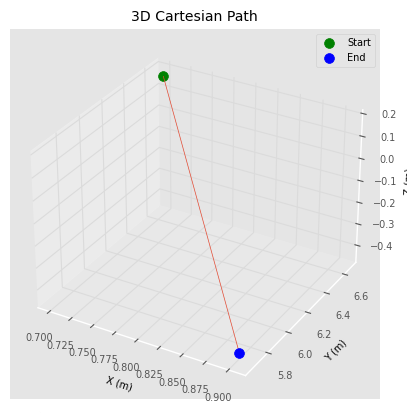

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1) 3D path of the end‑effector
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos_start[0], pos_start[1], pos_start[2], color='green', s=50, label="Start")
ax.scatter(pos_end[0], pos_end[1], pos_end[2], color='blue', s=50, label="End")
ax.plot(
    pos_traj[:,0],  # x
    pos_traj[:,1],  # y
    pos_traj[:,2],  # z
)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.set_zlabel('Z (m)')
ax.set_title('3D Cartesian Path')
ax.legend()
plt.show()

## Plotting Speed and Acceleration

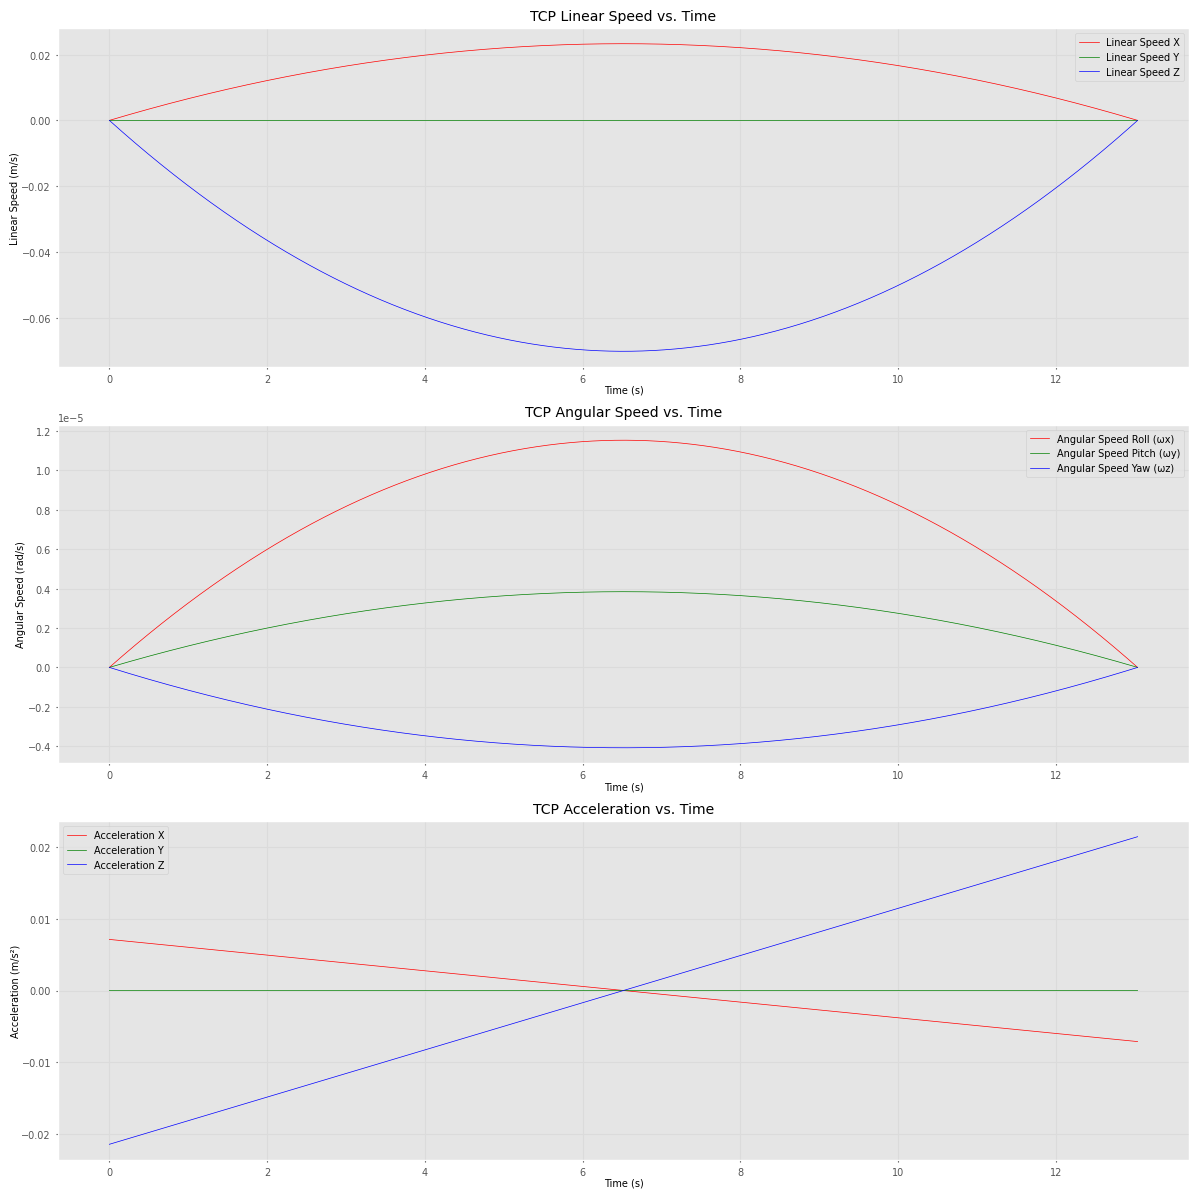

In [9]:
plt.figure(figsize=(12, 12))

# 1) Linear speeds
plt.subplot(3, 1, 1)
plt.plot(t_vec, speed_traj[:, 0], 'r-', label='Linear Speed X')
plt.plot(t_vec, speed_traj[:, 1], 'g-', label='Linear Speed Y')
plt.plot(t_vec, speed_traj[:, 2], 'b-', label='Linear Speed Z')
plt.xlabel("Time (s)")
plt.ylabel("Linear Speed (m/s)")
plt.title("TCP Linear Speed vs. Time")
plt.legend()
plt.grid(True)

# 2) Angular speeds
plt.subplot(3, 1, 2)
plt.plot(t_vec, speed_traj[:, 3], 'r-', label='Angular Speed Roll (ωx)')
plt.plot(t_vec, speed_traj[:, 4], 'g-', label='Angular Speed Pitch (ωy)')
plt.plot(t_vec, speed_traj[:, 5], 'b-', label='Angular Speed Yaw (ωz)')
plt.xlabel("Time (s)")
plt.ylabel("Angular Speed (rad/s)")
plt.title("TCP Angular Speed vs. Time")
plt.legend()
plt.grid(True)

# 3) Linear accelerations
plt.subplot(3, 1, 3)
plt.plot(t_vec, acc_traj[:, 0], 'r-', label='Acceleration X')
plt.plot(t_vec, acc_traj[:, 1], 'g-', label='Acceleration Y')
plt.plot(t_vec, acc_traj[:, 2], 'b-', label='Acceleration Z')
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s²)")
plt.title("TCP Acceleration vs. Time")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## REAL robot trajectory planning
ก่อนการคำนวน trajectory planning เราต้องลองว่า trajectory ที่เราคำนวนนั้นสามารถทำงานได้จริงหรือไม่ โดยลองหา inverse kinematic ของหุ่นยนต์ UR5e ว่ามี solution หรือไม่ โดยใช้ฟังก์ชัน `robot_get_ik(tcp_pose_list)` ซึ่งจะคืนค่ามาเป็น joint angle ของหุ่นยนต์ UR5e โดยคำสั่งนี้มาจ่าก class `robot_movement` ที่เราโหลดไว้ในตอนแรกซึ่งข้างในจะเป็น api ของหุ่นยนต์ UR5e ที่เราสามารถเรียกใช้ได้เลย

In [10]:
joint_trajectory = []  
for idx, T_pose in enumerate(traj_T):
    pos = T_pose.t.tolist() 
    orientation = T_pose.rpy() 
    tcp_pose_list = pos + list(orientation)
    q_joint = real_robot.robot_get_ik(tcp_pose_list)
    if q_joint is None:
        print(f"IK failed for waypoint {idx}.")
        break  # or handle the error as needed
    joint_trajectory.append(q_joint)
if len(joint_trajectory) != len(traj_T):
    raise RuntimeError("Incomplete joint trajectory. Please check IK solutions for all waypoints.")

print("Successfully computed joint trajectory for all waypoints.")

Successfully computed joint trajectory for all waypoints.


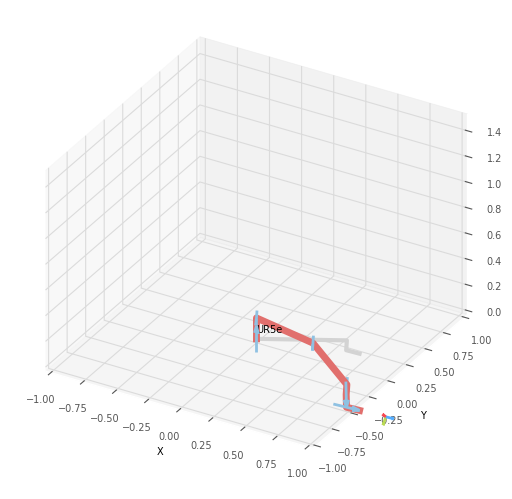

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'UR5e')

<Figure size 640x480 with 0 Axes>

In [11]:
# visualize the robot at Goal position
robotDH.plot(joint_trajectory[-1], block=False, limits=[-1, 1, -1, 1, 0, 1.5],vellipse=False)

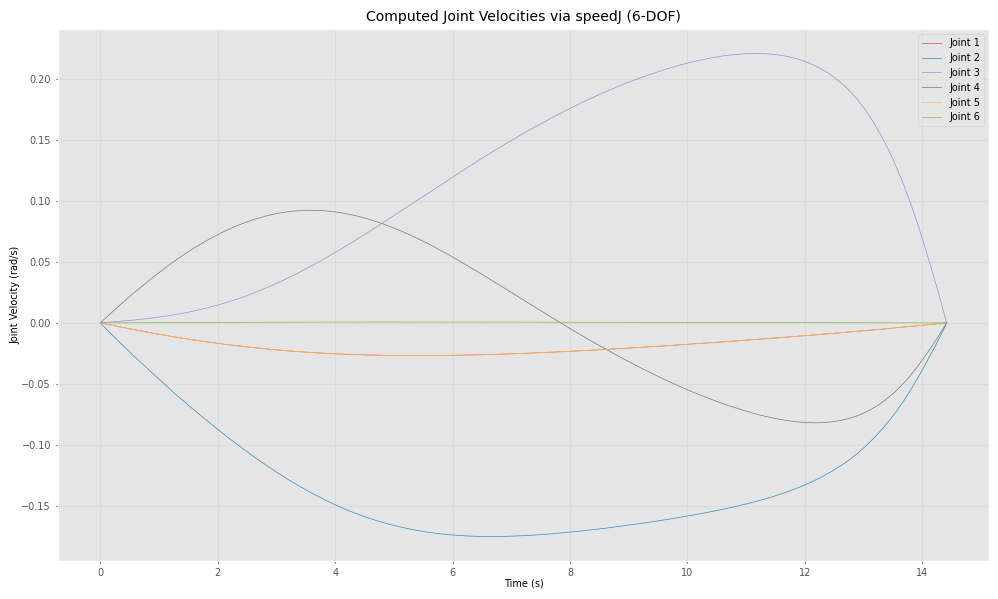

In [ ]:
dt                   = 1/100
joint_acceleration   = 0.25  # rad/s^2

computed_joint_velocities = []
time_stamps              = []
start_time               = time.time()

for i in range(len(traj_T)):

    t_cur = time.time() - start_time
    time_stamps.append(t_cur)
    v_ff = speed_traj[i]  # shape (6,)
    twist = v_ff

    q_current = joint_trajectory[i]
    J         = robotDH.jacob0(q_current)
    condJ     = np.linalg.cond(J)
    if condJ > 1e9:
        print(f"Aborting at step {i}: ill-conditioned Jacobian (cond={condJ:.2e})")
        break

    dq = np.linalg.pinv(J, rcond=1e-2) @ twist
    computed_joint_velocities.append(dq)

    real_robot.robot_speed_J(
        dq.tolist(),
        acceleration=joint_acceleration,
        time=dt
    )
    time.sleep(dt)

if computed_joint_velocities:
    computed_joint_velocities = np.vstack(computed_joint_velocities)
else:
    computed_joint_velocities = np.zeros((0, 6))

# Plotting
plt.figure(figsize=(10, 6))
for j in range(computed_joint_velocities.shape[1]):
    plt.plot(time_stamps,
             computed_joint_velocities[:, j],
             label=f'Joint {j+1}')
plt.xlabel("Time (s)")
plt.ylabel("Joint Velocity (rad/s)")
plt.title("Computed Joint Velocities via speedJ (6-DOF)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Result
![trajectory planning result](./images/trajectory_result.gif)

## Back to home position and release robot
หลังจากที่เราทำการคำนวน trajectory planning เสร็จแล้ว เราจะทำการกลับไปยังตำแหน่ง HOME_POS โดยใช้ฟังก์ชัน `robot_move_to_home()` ซึ่งจะทำการส่งคำสั่งให้หุ่นยนต์เคลื่อนที่ไปยังตำแหน่ง HOME_POS โดยอัตโนมัติ และปิดการเชื่อมต่อกับหุ่นยนต์ UR5e โดยใช้ฟังก์ชัน `robot_release` ซึ่งจะทำการปิดการเชื่อมต่อกับหุ่นยนต์ UR5e โดยอัตโนมัติ

In [13]:
real_robot.robot_move_speed_stop()
real_robot.robot_move_home()
real_robot.robot_release()


Moving to home position...
Arrived at home position.
